## 1. Set-up

In [1]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 2. 데이터 가져오기

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 40

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/val/*/*'))


print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1077
Pneumonia images count in training set: 3108


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [9]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

[]


In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [11]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [14]:

test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/data/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_basic = prepare_for_training(train_ds)
val_ds_basic = prepare_for_training(val_ds)

In [16]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_aug_ds = prepare_for_training_aug(train_ds)
val_aug_ds = prepare_for_training_aug(val_ds)

## 3. 데이터 시각화

(16, 180, 180, 3)
(16,)


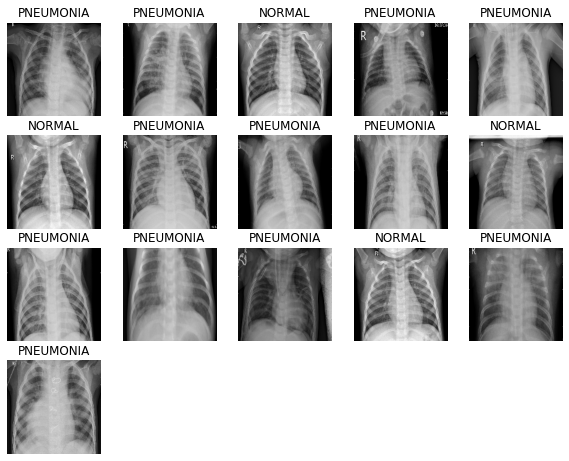

In [17]:
image_batch, label_batch = next(iter(train_ds_basic))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

(16, 180, 180, 3)
(16,)


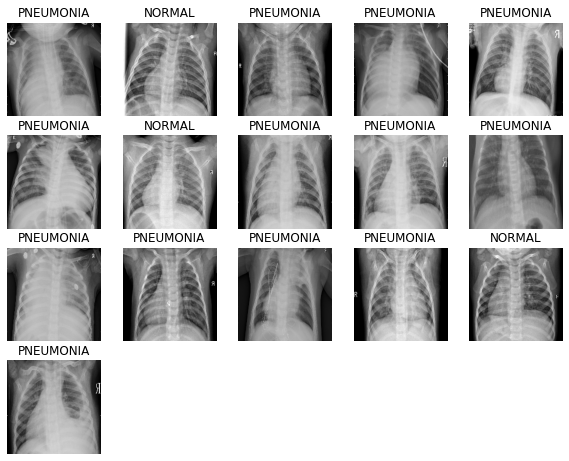

In [18]:
image_aug_batch, label_aug_batch = next(iter(train_aug_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_aug_batch.numpy(), label_aug_batch.numpy())

## 4. CNN 모델링

In [19]:
def conv_block(layer, filters):
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(layer)
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    return x

In [20]:
def dense_block(layer, units, dropout_rate=0.5, dropout=True):
    x = tf.keras.layers.Dense(units, activation='relu')(layer)
    x = tf.keras.layers.BatchNormalization()(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    return x

In [21]:
def build_model(dropout=True):
    input_layer = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    
    x = conv_block(x, 128)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = conv_block(x, 256)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = dense_block(x, 512, 0.7)
    x = dense_block(x, 128, 0.5)
    x = dense_block(x, 64, 0.3)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    
    return model

## 5. 데이터 imbalance 처리

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


## 6. 모델 훈련

In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
261/261 [==============================] - 92s 240ms/step - loss: 0.5802 - accuracy: 0.6993 - precision: 0.8979 - recall: 0.6682 - val_loss: 0.6499 - val_accuracy: 0.7413 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 2/40
261/261 [==============================] - 60s 231ms/step - loss: 0.2182 - accuracy: 0.9168 - precision: 0.9790 - recall: 0.9064 - val_loss: 0.9948 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 3/40
261/261 [==============================] - 61s 235ms/step - loss: 0.1981 - accuracy: 0.9228 - precision: 0.9742 - recall: 0.9196 - val_loss: 0.1462 - val_accuracy: 0.9404 - val_precision: 0.9286 - val_recall: 0.9961
Epoch 4/40
261/261 [==============================] - 62s 238ms/step - loss: 0.1631 - accuracy: 0.9352 - precision: 0.9799 - recall: 0.9316 - val_loss: 0.0903 - val_accuracy: 0.9692 - val_precision: 0.9804 - val_recall: 0.9779
Epoch 5/40
261/261 [==============================] - 63s 240ms/step - loss: 0.1257 - accura

In [27]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 6s 151ms/step - loss: 1.3646 - accuracy: 0.7901 - precision: 0.7515 - recall: 0.9923


## 7. 결과 확인과 시각화

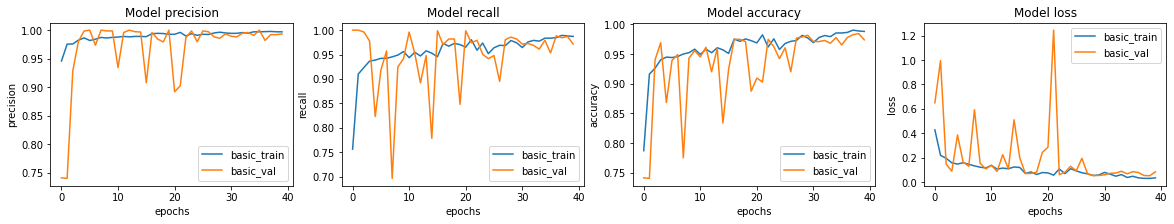

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['basic_train', 'basic_val', 'aug_train', 'aug_val'])

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 150ms/step - loss: 1.3646 - accuracy: 0.7901 - precision: 0.7515 - recall: 0.9923
Loss: 1.3646215200424194,
Accuracy: 0.7900640964508057,
Precision: 0.7514563202857971,
Recall: 0.9923076629638672
